In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Sample data
x1 = np.array([
    [1, 2], [1, 3], [2, 2], [2, 3], [3, 4], [7, 2], [7, 3], [8, 2], [8, 3], [9, 4],
    [8, 8], [8, 9], [9, 8], [9, 9], [10, 10], [4, 5], [6, 5], [6, 7],
])

from sklearn import datasets
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

In [5]:
x1,y=datasets[0][0]

In [6]:
#for i_dataset, (dataset, algo_params) in enumerate(datasets):
#    print(dataset)

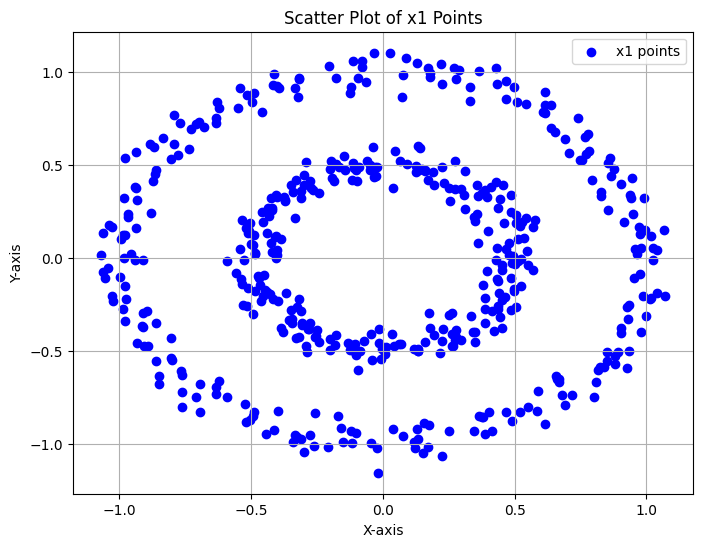

In [7]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x1[:, 0], x1[:, 1], c='blue', label='x1 points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of x1 Points')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# Function to create and normalize the distance matrix
def create_distance_matrix(zscores, metric):
    distance_matrix = pdist(zscores, metric=metric)
    A = squareform(distance_matrix)
    max_vals = np.max(A, axis=1, keepdims=True)
    D = (max_vals - A) / max_vals
    np.fill_diagonal(D, 0)
    return D


In [6]:
# Function to initialize clustering variables
def initialize_clustering_variables(D):
    n1 = D.shape[1] - 1
    C = np.zeros((n1 + 1, 4))
    return n1, C


In [7]:
# Function to perform the main clustering loop
def perform_clustering(D, n1):
    C = np.zeros((n1 + 1, 4))
    A = np.copy(D)
    for m in range(n1):
        B = np.sum(A, axis=1)
        nonzero_indices = np.nonzero(B)[0]
        if len(nonzero_indices) == 0:
            break
        min_value = np.min(B[nonzero_indices])
        min_indices = np.where(B == min_value)[0]
        C[m, 0] = min_indices[0]
        C[m, 1] = min_value
        A[min_indices[0], :] = 0
        A[:, min_indices[0]] = 0
    return C

In [8]:
# Function to calculate cluster thresholds and update C matrix
def calculate_cluster_thresholds(C, alfa, n1):
    C[0:n1, 2] = (C[0:n1, 1] - C[1:n1+1, 1]) / C[0:n1, 1]
    C[:, 3] = (C[:, 2] > alfa)
    return C


In [9]:
# Function to assign initial clusters based on thresholds
def assign_initial_clusters(C, n1):
    n, sigma = 1, 0
    S = np.zeros((C.shape[0], 1))
    for x1 in range(n1):
        if C[x1, 3] - C[x1 + 1, 3] == 1:
            S[int(C[x1, 0]), 0] = n
            n += 1
            if sigma + 1 > 1:
                sigma_max = np.max(C[x1 - sigma + 1:x1 + 1, 1])
                for i_sigma in range(x1 - sigma, x1 + 1):
                    if C[i_sigma, 1] != sigma_max:
                        S[int(C[i_sigma, 0]), 0] = 0
                        C[i_sigma, 3] = 0
                sigma = 0
        if C[x1, 3] + C[x1 + 1, 3] == 2:
            S[int(C[x1, 0]), 0] = n
            sigma += 1    
    m = np.sum(C[:, 3] == 0)
    return S, m, n

In [10]:
# Function to finalize cluster assignments
def finalize_clusters(S, A, m, n):
    zero_indices = np.where(S == 0)[0]
    m = len(zero_indices)
    for i in range(m):
        D = np.zeros((m - i, n - 1))
        for j in range(n - 1):
            c = S == (j + 1)
            r = np.where(S == 0)[0]
            D[:, j] = np.mean(A[np.ix_(r, c.flatten())], axis=1)
        ra, ca = np.where(D == np.max(D))
        S[r[ra[0]], 0] = ca[0] + 1
    return S

In [11]:
# Function to calculate DVI and Tightness indices
def calculate_dvis(data, labels):
    unique_labels = np.unique(labels)
    dvi1_sum = 0
    intra_cluster_density_sum = 0
    inter_cluster_density_sum = 0
    dvi3_sum = 0
    tightness_sum = 0

    for v in range(len(data)):
        cluster = labels[v]
        Cv = data[labels.flatten() == cluster]
        V_minus_Cv = data[labels.flatten() != cluster]

        intra_cluster_density = np.max(pdist(Cv)) if len(Cv) > 1 else 0
        inter_cluster_density = np.max(cdist([data[v]], V_minus_Cv)) if len(V_minus_Cv) > 0 else 0

        dvi1_sum += inter_cluster_density - intra_cluster_density
        intra_cluster_density_sum += intra_cluster_density
        inter_cluster_density_sum += inter_cluster_density
        dvi3_sum += inter_cluster_density / intra_cluster_density if intra_cluster_density > 0 else 0
        tightness_sum += np.mean(pdist(Cv)) if len(Cv) > 1 else 0

    dvi2 = inter_cluster_density_sum / intra_cluster_density_sum if intra_cluster_density_sum > 0 else 0
    tightness_avg = tightness_sum / len(unique_labels)
    return dvi1_sum, dvi2, dvi3_sum, tightness_avg

In [12]:
# Main clustering function
def yadro(zscores, metrika, alfa, visualize=False):
    D = create_distance_matrix(zscores, metrika)
    n1, C = initialize_clustering_variables(D)
    C = perform_clustering(D, n1)
    C = calculate_cluster_thresholds(C, alfa, n1)
    S, m, n = assign_initial_clusters(C, n1)
    S = finalize_clusters(S, D, m, n)
    dvi1, dvi2, dvi3, tightness_avg = calculate_dvis(zscores, S)
    
    print(f'tightness_avg: {tightness_avg}')
    print(f'DVI1: {dvi1}')
    print(f'DVI2: {dvi2}')
    print(f'DVI3: {dvi3}')

    if visualize:
        visualize_clusters(zscores, S)

    return S, dvi1, dvi2, dvi3,tightness_avg


In [13]:
# Function to visualize clusters
def visualize_clusters(data, cluster_labels):
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        plt.scatter(data[cluster_labels.flatten() == label, 0], data[cluster_labels.flatten() == label, 1], label=f'Cluster {int(label)}')
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()


In [14]:
# Function to find optimal clustering parameters
def find_optimal_parameters(graph, metrika, delta_values):
    best_params = None
    best_score = -np.inf

    for delta in delta_values:
        clusters, dvi1, dvi2, dvi3,tightness_avg = yadro(graph, metrika, delta)
         # Normalize and combine DVI scores and tightness_avg to get a single score
        combined_score = dvi1 - dvi2 - dvi3 + tightness_avg  # Adjust weights as needed
        if combined_score > best_score:
            best_score = combined_score
            best_params = delta

    return best_params, best_score


tightness_avg: 6.216157582131103
DVI1: 217.5809101969768
DVI2: 1.726896294945544
DVI3: 1920.5364138337754


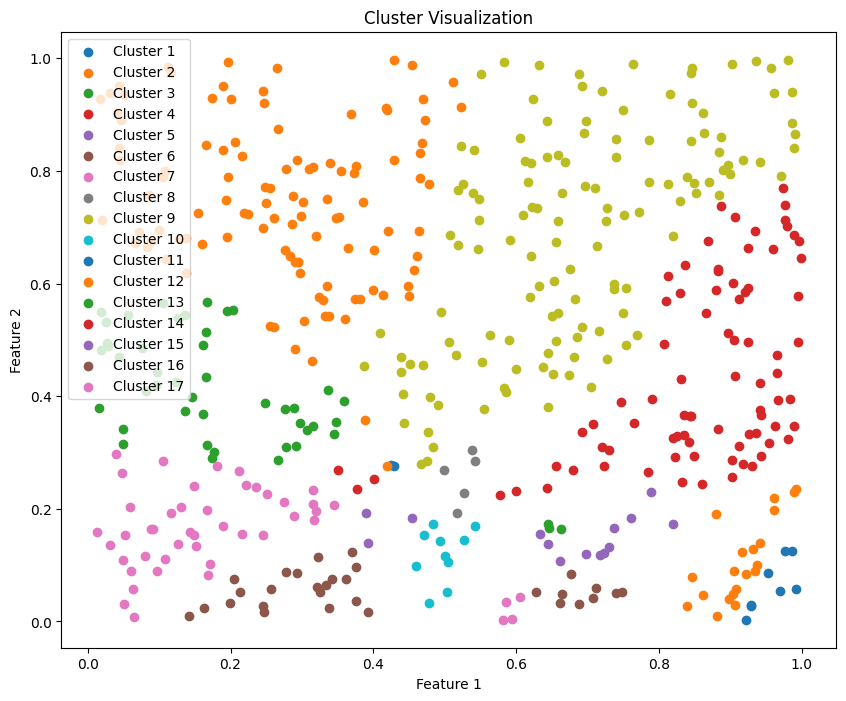

In [60]:
# Example usage
#alfa = np.arange(0, 0.8, 0.1)
#best_params, best_score = find_optimal_parameters(x1, 'euclidean', alfa)
#print("Best Parameters:", best_params)
#print("Best Score:", best_score)

zscores = x1  # Example data
S, dvi1, dvi2, dvi3,tightness_avg = yadro(zscores, 'euclidean', 0.01, visualize=True)